In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import export_graphviz
import graphviz
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from statsmodels.api import qqplot,add_constant
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import f1_score,roc_curve,auc
#경고문구 무시
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
matplotlib.rc('font', family = 'NanumGothic')

In [ ]:
# 파일 불러오기

df_order_products_train = pd.read_csv("/home/pirl/Downloads/4조_Grocery/grocery-order_products__train.csv")
df_order_products_prior = pd.read_csv("/home/pirl/Downloads/4조_Grocery/grocery-order_products__prior.csv")
df_orders = pd.read_csv("/home/pirl/Downloads/4조_Grocery/grocery-orders.csv")
df_products = pd.read_csv("/home/pirl/Downloads/4조_Grocery/grocery-products.csv")
df_aisles = pd.read_csv("/home/pirl/Downloads/4조_Grocery/grocery-aisles.csv")
df_departments = pd.read_csv("/home/pirl/Downloads/4조_Grocery/grocery-departments.csv")

In [116]:
df_order_products_all = pd.concat([df_order_products_prior, df_order_products_train])
df_order_products_all_merged = pd.merge(df_order_products_all, df_products, on='product_id', how='left')
df_order_products_all_merged = pd.merge(df_order_products_all_merged, df_aisles, on='aisle_id', how='left')
df_order_products_all_merged = pd.merge(df_order_products_all_merged, df_departments, on='department_id', how='left')
df_order_products_all_merged = pd.merge(df_order_products_all_merged, df_orders, on='order_id', how='left')
# order_number > 1 결측치
nan_data = df_order_products_all_merged[(df_order_products_all_merged['days_since_prior_order'].isnull()) & (df_order_products_all_merged['order_number'] != 1)]

# 평균값 계산 데이터 생성
other_data = pd.DataFrame()
for i in nan_data['user_id']:
    each_other_data = df_order_products_all_merged[(df_order_products_all_merged['user_id'] == i) & (df_order_products_all_merged['order_number'] != 1)]
    other_data = other_data.append(each_other_data)

# 평균값 데이터
other_data['days_since_prior_order'] = other_data['days_since_prior_order'].fillna(other_data.groupby('user_id')['days_since_prior_order'].transform('mean'))

# 처음 구매 데이터
df_order_products_all_merged_first = df_order_products_all_merged[(df_order_products_all_merged['days_since_prior_order'].isnull()) & (df_order_products_all_merged['order_number'] == 1)]

# 전체 데이터에서 처음 구매 데이터와 평균값 계산 데이터 삭제
temp1=df_order_products_all_merged.drop(index = df_order_products_all_merged_first.index)
temp1.reset_index(drop = True, inplace = True)

temp2=df_order_products_all_merged.drop(index = other_data.index)
temp2.reset_index(drop = True, inplace = True)
temp3=pd.merge(temp1, temp2, how = 'inner')

# 삭제한 데이터에서 새로 바뀐 데이터 삽입
df_order_products_all_merged_refined = pd.concat([other_data, temp3])
df_order_products_all_merged_refined = df_order_products_all_merged_refined.sort_values(['user_id'], ascending=[True])
df_order_products_all_merged_refined = df_order_products_all_merged_refined.reset_index(drop=True)
# 샘플링 파일 생성(10만개)
df_order_products_all_merged_refined_sample = df_order_products_all_merged_refined[df_order_products_all_merged_refined['user_id'] < 672]
df_order_products_all_merged_refined_sample.isnull().sum()

order_id                  0
product_id                0
add_to_cart_order         0
reordered                 0
product_name              0
aisle_id                  0
department_id             0
aisle                     0
department                0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
dtype: int64

In [117]:
#1번재 상품 마다 재주문율

#* 재주문율  = 재구매 / (처음구매 + 재구매) * 100
df_product_by_reordered = df_order_products_all_merged_refined_sample.groupby(["product_id"])["reordered"].aggregate("mean").reset_index()
reordered_ratio = df_product_by_reordered.rename(columns = {'reordered': 'product_by_reordered'})


# 2번째 상품의 주문 텀기간 평균
df_product_by_term_mean = df_order_products_all_merged_refined_sample.groupby(["product_id"])["days_since_prior_order"].aggregate("mean").reset_index()
df_product_days_term = df_product_by_term_mean.rename(columns = {'days_since_prior_order': 'product_by_days_since_prior_order'})

#3번째 상품의 주문 순서의 중앙값
df_product_by_seq_median = df_order_products_all_merged_refined_sample.groupby(["product_id"])["add_to_cart_order"].aggregate("median").reset_index()
df_product_add = df_product_by_seq_median.rename(columns = {'add_to_cart_order': 'product_by_add_to_cart_order'})

#4번째 상품 마다의 시간 평균
df_product_by_hour_median = df_order_products_all_merged_refined_sample.groupby(["product_id"])["order_hour_of_day"].aggregate("mean").reset_index()
df_product_hour = df_product_by_hour_median.rename(columns = {'order_hour_of_day': 'product_by_order_hour_of_day'})


# 주기당 재구매율
df_product_by_days = df_order_products_all_merged_refined_sample.groupby(["days_since_prior_order"])["reordered"].aggregate("mean").reset_index()
df_product_by_days.columns=['days_since_prior_order','order_ratio_by_days']

df_order_products_all_merged_refined_sample_merged = pd.merge(df_order_products_all_merged_refined_sample,df_product_by_days, on=['days_since_prior_order'],how='left')
df_order_products_all_merged_refined_sample_merged = pd.merge(df_order_products_all_merged_refined_sample_merged, reordered_ratio, on=['product_id'], how='left')
df_order_products_all_merged_refined_sample_merged = pd.merge(df_order_products_all_merged_refined_sample_merged, df_product_days_term, on=['product_id'], how='left')
df_order_products_all_merged_refined_sample_merged = pd.merge(df_order_products_all_merged_refined_sample_merged, df_product_add, on=['product_id'], how='left')
df_order_products_all_merged_refined_sample_merged = pd.merge(df_order_products_all_merged_refined_sample_merged, df_product_hour, on=['product_id'], how='left')
df_order_products_all_merged_refined_sample_merged.head()
df_order_products_all_merged_refined_sample_merged.isnull().sum()

order_id                             0
product_id                           0
add_to_cart_order                    0
reordered                            0
product_name                         0
aisle_id                             0
department_id                        0
aisle                                0
department                           0
user_id                              0
eval_set                             0
order_number                         0
order_dow                            0
order_hour_of_day                    0
days_since_prior_order               0
order_ratio_by_days                  0
product_by_reordered                 0
product_by_days_since_prior_order    0
product_by_add_to_cart_order         0
product_by_order_hour_of_day         0
dtype: int64

In [118]:
# 분석에 불필요한 데이터 삭제
df_order_products_all_merged_refined_sample = df_order_products_all_merged_refined_sample.drop(['order_id', 'product_id', 'product_name', 'aisle_id', 'department_id', 'aisle', 'user_id', 'eval_set', 'department'], 1)
df_order_products_all_merged_refined_sample
df_raw_y = df_order_products_all_merged_refined_sample[['reordered']]
df_raw_x = df_order_products_all_merged_refined_sample.drop('reordered', axis = 1, inplace = False)
# 변수형태 확인
list_var_char= list(df_raw_x.select_dtypes(include='object').columns)
list_var_char
# 데이터 분할(train(0.7) : validation(0.3) : test(0.3) 비율)
# 샘플링 파일 생성(train 7만개) 70515/100106
df_train_x = df_raw_x.iloc[0:40081, :]
df_train_y = df_raw_y.iloc[0:40081, :]

df_validation_x = df_raw_x.iloc[40081:70516, :]
df_validation_y = df_raw_y.iloc[40081:70516, :]

df_test_x = df_raw_x.iloc[70516:100107, :]
df_test_y = df_raw_y.iloc[70516:100107, :]

print('train data X size : {}'.format(df_train_x.shape))
print('train data Y size : {}'.format(df_train_y.shape))

print('validation data X size : {}'.format(df_validation_x.shape))
print('validation data Y size : {}'.format(df_validation_y.shape))

print('test data X size : {}'.format(df_test_x.shape))
print('test data Y size : {}'.format(df_test_y.shape))

train data X size : (40081, 5)
train data Y size : (40081, 1)
validation data X size : (30435, 5)
validation data Y size : (30435, 1)
test data X size : (29591, 5)
test data Y size : (29591, 1)


In [106]:
#연습모델
knn_un=KNeighborsClassifier()
knn_un.fit(df_train_x,df_train_y)
print('score on training set:{:.3f}'.format(knn_un.score(df_train_x,df_train_y)))
print('score on validation set:{:.3f}'.format(knn_un.score(df_validation_x,df_validation_y)))

score on training set:0.825
score on validation set:0.640


N SCORE


,n,TrainScore,validationScore
0,1,0.987,0.606
1,2,0.860,0.563
2,3,0.873,0.626
3,4,0.836,0.604
4,5,0.825,0.640
5,6,0.799,0.623
6,7,0.790,0.649
7,8,0.779,0.636
8,9,0.773,0.655
9,10,0.765,0.646


Text(0.5, 0, 'n')

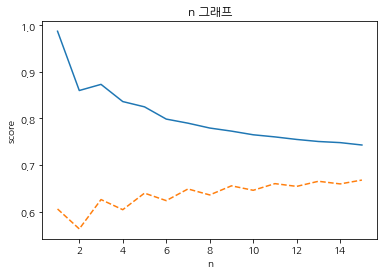

In [108]:
#n 최적 값 찾기
train_score=[]; validation_score=[]
para_n=[i for i in range(1,16)]
for v_n_neighbors in para_n:
    knn=KNeighborsClassifier(n_neighbors=v_n_neighbors)
    knn.fit(df_train_x,df_train_y)
    train_score.append(knn.score(df_train_x,df_train_y))
    validation_score.append(knn.score(df_validation_x,df_validation_y))

#n 스코어
print('N SCORE')
df_score_knn = pd.DataFrame()
df_score_knn['n']=para_n
df_score_knn['TrainScore']=train_score
df_score_knn['validationScore']=validation_score
display(df_score_knn.round(3))
#n 그래프
plt.title('n 그래프')
plt.plot(para_n,train_score,linestyle='-',label='Train Score')
plt.plot(para_n,validation_score,linestyle='--',label='validation Score')
plt.ylabel('score'); plt.xlabel('n')


#n=9

W SCORE


,TrainScore_distance,TrainScore_uniform,validationScore_distance,validationScore_uniform
neighbors,,,,
1,0.987425,0.987425,0.605553,0.605553
2,0.987550,0.860083,0.592279,0.562707
3,0.988124,0.873282,0.625497,0.625793
4,0.988124,0.836331,0.622803,0.604009
5,0.988124,0.824979,0.638278,0.639593
6,0.988124,0.798683,0.637424,0.623493
7,0.988124,0.789900,0.646460,0.648563
8,0.988124,0.779472,0.649121,0.635715
9,0.988124,0.772835,0.652538,0.655298


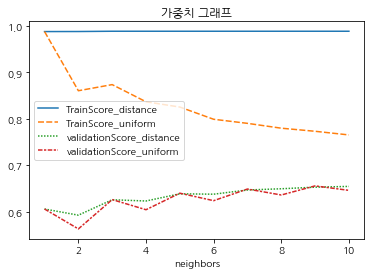

In [110]:
#가중치 최적 값 찾기
train_score2=[]; validation_score2=[]
para_n=[i for i in range(1,11)]*2
para_w=(['uniform']*10)+(['distance']*10)
for (v_n_neighbors,v_weights) in zip(para_n,para_w):
    knn=KNeighborsClassifier(n_neighbors=v_n_neighbors,weights=v_weights)
    knn.fit(df_train_x,df_train_y)
    train_score2.append(knn.score(df_train_x,df_train_y))
    validation_score2.append(knn.score(df_validation_x,df_validation_y))

#가중치 스코어
print('W SCORE')
df_score_w = pd.DataFrame()
df_score_w['neighbors']=para_n
df_score_w['weight']=para_w
df_score_w['TrainScore']=train_score2
df_score_w['validationScore']=validation_score2


#가중치 표

df_score_w_pivot=df_score_w.pivot(index='neighbors',columns='weight',values=['TrainScore','validationScore'])
level0=df_score_w_pivot.columns.get_level_values(0)
level1=df_score_w_pivot.columns.get_level_values(1)
df_score_w_pivot.columns=level0+'_'+level1
display(df_score_w_pivot)

#가중치 그래프

plt.title('가중치 그래프')
sns.lineplot(data=df_score_w_pivot)


#uniform

metric SCORE


,neighbors,metric,TrainScore,validationScore
0,1,minkowski,0.987,0.606
1,2,minkowski,0.860,0.563
2,3,minkowski,0.873,0.626
3,4,minkowski,0.836,0.604
4,5,minkowski,0.825,0.640
5,6,minkowski,0.799,0.623
6,7,minkowski,0.790,0.649
7,8,minkowski,0.779,0.636
8,9,minkowski,0.773,0.655
9,10,minkowski,0.765,0.646


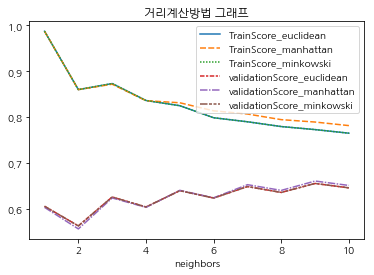

In [112]:
#최적 거리계산 방법 찾기
train_score3=[]; validation_score3=[]
para_n=[i for i in range(1,11)]*3
para_m=(['minkowski']*10)+(['euclidean']*10)+(['manhattan']*10)

for (v_n_neighbors,v_metric) in zip(para_n,para_m):
    knn=KNeighborsClassifier(weights='uniform',n_neighbors=v_n_neighbors,metric=v_metric)
    knn.fit(df_train_x,df_train_y)
    train_score3.append(knn.score(df_train_x,df_train_y))
    validation_score3.append(knn.score(df_validation_x,df_validation_y))


                       
#거리계산방법 스코어
print('metric SCORE')
df_score_m = pd.DataFrame()
df_score_m['neighbors']=para_n
df_score_m['metric']=para_m
df_score_m['TrainScore']=train_score3
df_score_m['validationScore']=validation_score3
display(df_score_m.round(3))

#거리계산방법 그래프

plt.title('거리계산방법 그래프')
df_score_m_pivot=df_score_m.pivot(index='neighbors',columns='metric',values=['TrainScore','validationScore'])
level0=df_score_m_pivot.columns.get_level_values(0)
level1=df_score_m_pivot.columns.get_level_values(1)
df_score_m_pivot.columns=level0+'_'+level1
sns.lineplot(data=df_score_m_pivot)

plt.show()

#manhattan

In [113]:
#최종모델
knn_final=KNeighborsClassifier(n_neighbors=9,weights='uniform',metric='manhattan')
knn_final.fit(df_train_x,df_train_y)
print('score on training set:{:.3f}'.format(knn_final.score(df_train_x,df_train_y)))
print('score on test set:{:.3f}'.format(knn_final.score(df_test_x,df_test_y)))

y_pred=knn_final.predict(df_test_x)
print('confusion matrix:\n{}'.format(confusion_matrix(df_test_y,y_pred)))


score on training set:0.789
score on test set:0.646
confusion matrix:
[[ 5297  5959]
 [ 4515 13820]]


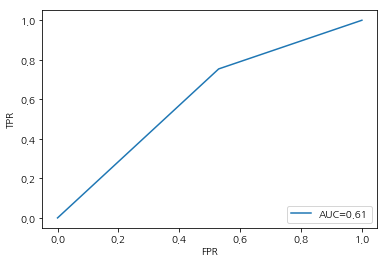

In [114]:
#모델평가
model=['knn']
train_accuracy=[]; test_accuracy=[]
model_f1_score=[]
model_auc=[]
train_accuracy.append(knn_final.score(df_train_x,df_train_y))
test_accuracy.append(knn_final.score(df_test_x,df_test_y))
y_pred=knn_final.predict(df_test_x)
fpr,tpr,thresholds=roc_curve(df_test_y,y_pred)
roc_auc=auc(fpr,tpr)
model_auc.append(roc_auc)

plt.plot(fpr,tpr,label='AUC=%0.2f'%roc_auc)
plt.legend(loc='lower right')
plt.ylabel('TPR'); plt.xlabel('FPR')
plt.show()

model_f1_score.append(f1_score(df_test_y,y_pred))


,trainaccuracy,testaccuracy,f1score,auc
knn,0.789,0.646,0.725,0.612


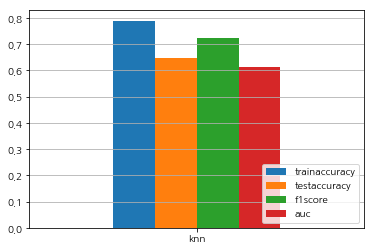

In [115]:
df_eval=pd.DataFrame(index=model)
df_eval['trainaccuracy']=train_accuracy
df_eval['testaccuracy']=test_accuracy
df_eval['f1score']=model_f1_score
df_eval['auc']=model_auc
display(df_eval.round(3))


df_eval.plot.bar(rot=0)
plt.legend(loc='lower right')
plt.grid(axis='y')

# 연관분석

In [121]:
basket = pd.read_csv("rules_total_.csv")
basket[basket['lift']>=1]

,Unnamed: 0,itemA,itemB,freqAB,supportAB,freqA,supportA,freqB,supportB,confidenceAtoB,confidenceBtoA,lift
0,0,2nd Foods Chicken & Gravy,2nd Foods Turkey Meat,167,0.005288,527,0.016688,273,0.008645,0.316888,0.611722,36.655380
1,1,Smoothie Fruits Squished The Purple One Over 6...,"Smoothie Fruits, Squished, The Green One, Over...",159,0.005035,526,0.016657,604,0.019127,0.302281,0.263245,15.804071
2,2,Dairy Free Greek Yogurt Strawberry,Dairy Free Greek Yogurt Blueberry,188,0.005953,656,0.020773,602,0.019063,0.286585,0.312292,15.033221
3,3,Organic Nondairy Strawberry Cashew Yogurt,Organic Cashew Nondairy Blueberry Yogurt,276,0.008740,987,0.031255,687,0.021755,0.279635,0.401747,12.853746
4,5,Grassfed Whole Milk Strawberry Yogurt,Organic Strawberry Grassfed Whole Milk Yogurt,166,0.005257,658,0.020837,731,0.023149,0.252280,0.227086,10.898315
5,6,Compostable Forks,Plastic Knives,158,0.005003,1581,0.050065,295,0.009342,0.099937,0.535593,10.697880
6,9,Organic Strawberry Grassfed Whole Milk Yogurt,Grassfed Whole Milk Strawberry Yogurt,160,0.005067,731,0.023149,658,0.020837,0.218878,0.243161,10.504400
7,10,Organic Forest Berry Cream On Top Whole Milk Y...,Organic Blueberry Cream On Top Whole Milk Yogurt,161,0.005098,672,0.021280,777,0.024605,0.239583,0.207207,9.737111
8,13,Revel Berry Yerba Mate,Organic Bluephoria Yerba Mate,219,0.006935,1094,0.034644,653,0.020678,0.200183,0.335375,9.680731
9,19,Organic Strawberry Chia Lowfat 2% Cottage Cheese,Organic Cottage Cheese Blueberry Acai Chia,317,0.010038,1215,0.038475,878,0.027804,0.260905,0.361048,9.383892
